#### Imports and Testing

In [1]:
import numpy
import cv2
from cv2.data import haarcascades
import time

In [2]:
import io
import IPython.display
from IPython.display import display, Image
from IPython.display import clear_output
import time

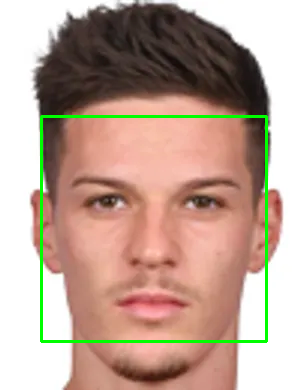

In [3]:
face_cascade = cv2.CascadeClassifier(haarcascades + "haarcascade_frontalface_default.xml")
img = cv2.imread('dump/man.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# cv2.imshow('Facial Detection', img)
# cv2.waitKey(5000)  
# cv2.destroyAllWindows()

# convert image to png format and display in Jupyter notebook
ret, buffer = cv2.imencode('.png', img)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

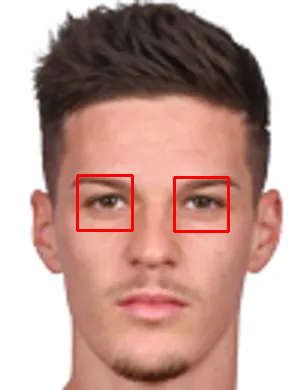

In [7]:
eye_detector = cv2.CascadeClassifier(haarcascades + "haarcascade_eye.xml")
img = cv2.imread('dump/man.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

eyes = eye_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

for (x, y, w, h) in eyes:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
cv2.imshow('Eye Detection', img)
# cv2.waitKey(0)
# #time.sleep(5)
# cv2.destroyAllWindows()

ret, buffer = cv2.imencode('.png', img)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

##### Instantiate just Face and Eye detection

In [8]:
face_cascade = cv2.CascadeClassifier(haarcascades + "haarcascade_frontalface_default.xml")
eye_detector = cv2.CascadeClassifier(haarcascades + "haarcascade_eye.xml")

### Eye detection on video stream

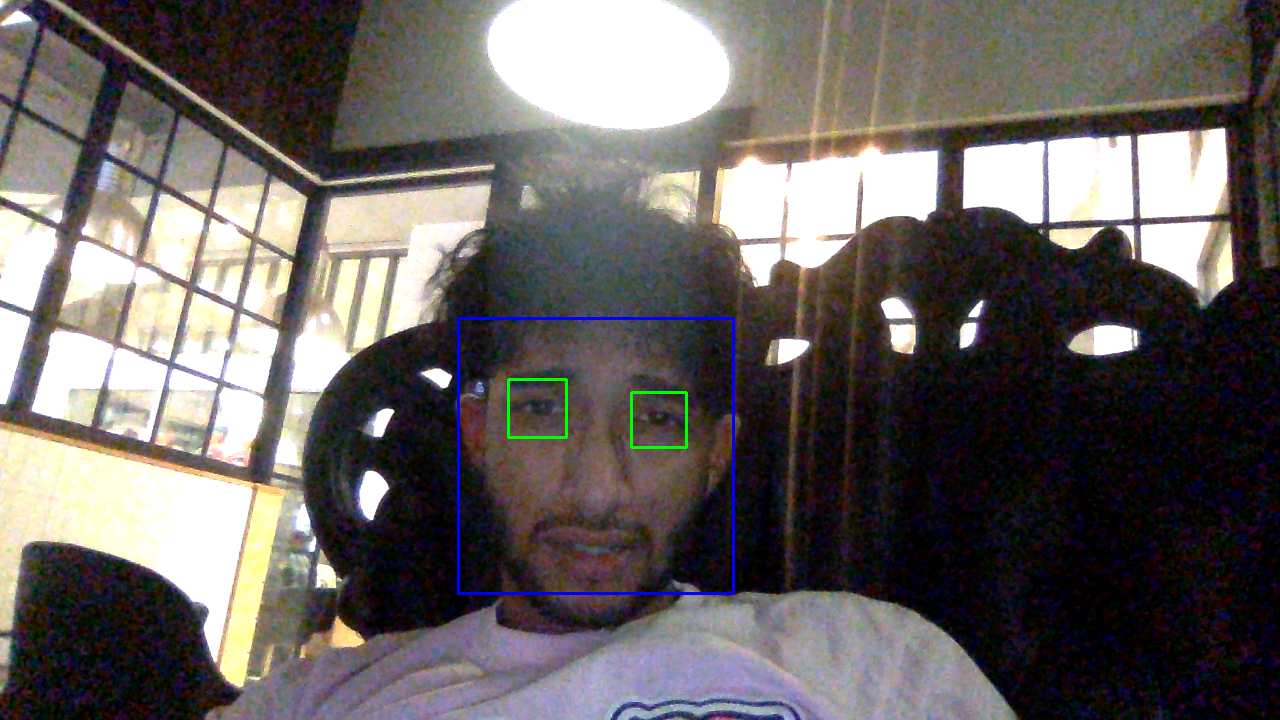

In [5]:
# Initialize the webcam
cap = cv2.VideoCapture(0)

# Set the maximum number of frames to display
max_frames = 100
frame_count = 0

while frame_count < max_frames:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Convert the frame to grayscale for better detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Extract the face region for eye detection
        face_gray = gray[y:y+h, x:x+w]
        face_color = frame[y:y+h, x:x+w]

        # Detect eyes in the face region
        eyes = eye_detector.detectMultiScale(face_gray)

        for (ex, ey, ew, eh) in eyes:
            # Draw a rectangle around the eyes
            cv2.rectangle(face_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)

    # Encode the frame as a PNG image
    ret, buffer = cv2.imencode('.png', frame)
    io_buf = io.BytesIO(buffer)

    # Display the image in the notebook
    IPython.display.display(IPython.display.Image(data=io_buf.getvalue()))

    # Clear the output to update the display with the next frame
    clear_output(wait=True)
    
    # Increment the frame counter
    frame_count += 1
    
    # Control the frame rate (optional)
    time.sleep(0.1)

# Release the webcam
cap.release()


#### Now perform blob detection

Source: https://github.com/stepacool/Eye-Tracker/blob/master/project/capturers/haar_blob.py

In [5]:
def get_eyes(face):
    eyes = eye_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    left = None
    right = None
    
    if len(eyes) == 0:
        return None, None
    
    else:
        for (x, y, w, h) in eyes:
            # source: https://github.com/stepacool/Eye-Tracker/blob/master/project/capturers/haar_blob.py
            
            eye_center = int(float(x) + (float(w) / float(2))) 
            if int(face.shape[1] * 0.1) < eye_center < int(face.shape[1] * 0.4):
                left = face[y : y + h, x : x + w]
            elif int(face.shape[1] * 0.5) < eye_center < int(face.shape[1] * 0.9):
                right = face[y : y + h, x : x + w]
            else:
                pass  # false positive - nostrill
            
        return left, right
    

Test function on sample face

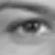

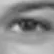

In [12]:
img = cv2.imread('dump/man.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

left, right = get_eyes(gray)

ret, buffer = cv2.imencode('.png', left)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

ret, buffer = cv2.imencode('.png', right)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

We should probably get rid of eyebrows too

In [18]:
def no_eyebrows (eye):
    # get rid of the top 30 percent of the image of eyes so the only dark blobs are the pupils
    if eye is not None:
        eye = eye[int(eye.shape[0] * 0.2):, :]
        
    return eye

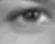

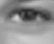

In [25]:
img = cv2.imread('dump/man.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

left, right = get_eyes(gray)

left = no_eyebrows(left)
right = no_eyebrows(right)

ret, buffer = cv2.imencode('.png', left)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

ret, buffer = cv2.imencode('.png', right)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

In [22]:
def draw(img, blobs, dest=None):
    if dest is None:
        dest = img
    return cv2.drawKeypoints(
        img,
        blobs,
        dest,
        (0, 0, 255),
        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
    )


In [24]:
# Set up the blob detector parameters
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 10
params.maxThreshold = 200
params.filterByArea = True
params.minArea = 15
params.filterByCircularity = True
params.minCircularity = 0.1
params.filterByConvexity = True
params.minConvexity = 0.87
params.filterByInertia = True
params.minInertiaRatio = 0.01
params.blobColor = 255

# params = cv2.SimpleBlobDetector_Params()
# params.filterByArea = True
# params.maxArea = 1500

detector = cv2.SimpleBlobDetector_create(params)

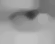

In [26]:
left = cv2.erode(left, None, iterations=2)
left = cv2.dilate(left, None, iterations=4)
left = cv2.medianBlur(left, 5)

# keypoints = detector.detect(left)

ret, buffer = cv2.imencode('.png', left)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

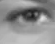

In [53]:
left_pupil = detector.detect(left)

left = draw(left, left_pupil)

ret, buffer = cv2.imencode('.png', left)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

In [5]:
cap.release()

Account for the fact that we are drwaing directly onto the face now

In [14]:
def draw(img, blobs, eye_coordinates, dest=None): #
    if dest is None:
        dest = img

    for blob in blobs:
        x, y = eye_coordinates
        center = (int(blob.pt[0]) + x, int(blob.pt[1]) + y)
        radius = int(blob.size / 2)
        cv2.circle(dest, center, radius, (0, 0, 255), 2)

    return dest


Practice this drwaing function in the original picture of the man

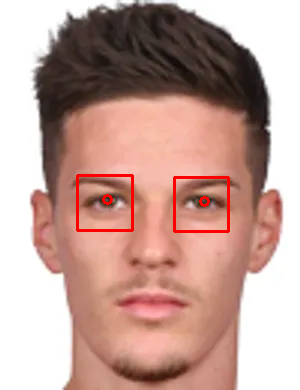

In [20]:
eye_detector = cv2.CascadeClassifier(haarcascades + "haarcascade_eye.xml")
img = cv2.imread('dump/man.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

eyes = eye_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

for (x, y, w, h) in eyes:
    
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    left, right = get_eyes(gray)

    left = cv2.erode(left, None, iterations=2)
    left = cv2.dilate(left, None, iterations=4)
    left = cv2.medianBlur(left, 5)

    left_pupil = detector.detect(left)

    img = draw(img, left_pupil, (x, y))
    
cv2.imshow('Eye Detection', img)
# cv2.waitKey(0)
# #time.sleep(5)
# cv2.destroyAllWindows()

left, right = get_eyes(gray)

left = cv2.erode(left, None, iterations=2)
left = cv2.dilate(left, None, iterations=4)
left = cv2.medianBlur(left, 5)

left_pupil = detector.detect(left)

img = draw(img, left_pupil, (x, y))

ret, buffer = cv2.imencode('.png', img)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))

In [12]:
# lowering thresholds to detect pupils in dark environments

# Set up the blob detector parameters
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 10
params.maxThreshold = 200
params.filterByArea = True
params.minArea = 15
params.filterByCircularity = True
params.minCircularity = 0.1
params.filterByConvexity = True
params.minConvexity = 0.87
params.filterByInertia = True
params.minInertiaRatio = 0.01
params.blobColor = 255

params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.maxArea = 1500

detector = cv2.SimpleBlobDetector_create(params)

In [29]:
# Initialize the webcam
cap = cv2.VideoCapture(0)

# Set the maximum number of frames to display
max_frames = 25
frame_count = 0

while frame_count < max_frames:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Convert the frame to grayscale for better detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Extract the face region for eye detection
        face_gray = gray[y:y+h, x:x+w]
        
        # applying histogram equalization to enhance the contrast of the grayscale image:
        face_gray = cv2.equalizeHist(face_gray)

        face_color = frame[y:y+h, x:x+w]

        # Detect eyes in the face region
        eyes = eye_detector.detectMultiScale(face_gray)
        
        print("here -1")

        for (ex, ey, ew, eh) in eyes:
            # Draw a rectangle around the eyes
            cv2.rectangle(face_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
            
            # Get the left and right eyes using the get_eyes function
            left, right = get_eyes(face_gray)

            print("here 0")

            if left is not None:
                left_no_eyebrows = no_eyebrows(left)
                print("here 1")
                if left_no_eyebrows.size > 0:
                    print("here 2")
                    left_processed = cv2.erode(left_no_eyebrows, None, iterations=1)
                    left_processed = cv2.dilate(left_processed, None, iterations=3)
                    left_processed = cv2.medianBlur(left_processed, 5)
                    left_blobs = detector.detect(left_processed)
                    #draw(face_color, left_blobs, (x, y))
                    left_f = draw(left_no_eyebrows, left_blobs)
                    ret, buffer = cv2.imencode('.png', left_f)
                    io_buf = io.BytesIO(buffer)
                    display(Image(io_buf.getvalue()))

            if right is not None:
                right_no_eyebrows = no_eyebrows(right)
                if right_no_eyebrows.size > 0:
                    right_processed = cv2.erode(right_no_eyebrows, None, iterations=1)
                    right_processed = cv2.dilate(right_processed, None, iterations=3)
                    right_processed = cv2.medianBlur(right_processed, 5)
                    right_blobs = detector.detect(right_processed)
                    #draw(face_color, right_blobs, (x, y))

            

    # Encode the frame as a PNG image
    ret, buffer = cv2.imencode('.png', frame)
    io_buf = io.BytesIO(buffer)

    # # Display the image in the notebook
    # IPython.display.display(IPython.display.Image(data=io_buf.getvalue()))

    # Clear the output to update the display with the next frame
    clear_output(wait=True)
    
    # Increment the frame counter
    frame_count += 1
    
    # Control the frame rate (optional)
    time.sleep(0.1)

# Release the webcam
cap.release()


In [6]:
import logging
from typing import Optional

import numpy
from cv2.data import haarcascades

logger = logging.getLogger(__name__)


class CV2Error(Exception):
    pass

class HaarCascadeBlobCapture:
    """
    Class captures face and eyes using Haar Cascades.
    Detectes pupils using image processing with blob detection.
    Gaze estimation can be achieved by extracting x, y coordinates of the blobs
    Detailed description can be found here:
    https://medium.com/@stepanfilonov/tracking-your-eyes-with-python-3952e66194a6
    """

    face_detector = cv2.CascadeClassifier(haarcascades + "haarcascade_frontalface_default.xml")
    eye_detector = cv2.CascadeClassifier(haarcascades + "haarcascade_eye.xml")
    blob_detector = None

    def __init__(self):
        self.previous_left_blob_area = 1
        self.previous_right_blob_area = 1
        self.previous_left_keypoints = None
        self.previous_right_keypoints = None

    def init_blob_detector(self):
        detector_params = cv2.SimpleBlobDetector_Params()
        detector_params.filterByArea = True
        detector_params.maxArea = 1500
        self.blob_detector = cv2.SimpleBlobDetector_create(detector_params)

    def detect_face(self, img: numpy.ndarray) -> Optional[numpy.ndarray]:
        """
        Capture the biggest face on the frame, return it
        """

        coords = self.face_detector.detectMultiScale(img, 1.3, 5)

        if len(coords) > 1:
            biggest = (0, 0, 0, 0)
            for i in coords:
                if i[3] > biggest[3]:
                    biggest = i
            # noinspection PyUnboundLocalVariable
            biggest = numpy.array([i], numpy.int32)
        elif len(coords) == 1:
            biggest = coords
        else:
            return None

        for (x, y, w, h) in biggest:
            frame = img[y : y + h, x : x + w]
            return frame

    @staticmethod
    def _cut_eyebrows(img):
        """
        Primitively cut eyebrows out of an eye frame by simply cutting the top ~30% of the frame
        """
        if img is None:
            return img
        height, width = img.shape[:2]
        img = img[15:height, 0:width]  # cut eyebrows out (15 px)

        return img

    def detect_eyes(self, face_img: numpy.ndarray, cut_brows=True):
        """
        Detect eyes, optionally cut the eyebrows out
        """
        coords = self.eye_detector.detectMultiScale(face_img, 1.3, 5)

        left_eye = right_eye = None

        if coords is None or len(coords) == 0:
            return left_eye, right_eye
        for (x, y, w, h) in coords:
            eye_center = int(float(x) + (float(w) / float(2)))
            if int(face_img.shape[0] * 0.1) < eye_center < int(face_img.shape[1] * 0.4):
                left_eye = face_img[y : y + h, x : x + w]
            elif int(face_img.shape[0] * 0.5) < eye_center < int(face_img.shape[1] * 0.9):
                right_eye = face_img[y : y + h, x : x + w]
            else:
                pass  # false positive - nostrill

            if cut_brows:
                return self._cut_eyebrows(left_eye), self._cut_eyebrows(right_eye)
            return left_eye, right_eye

    def blob_track(self, img, threshold, prev_area):
        _, img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
        img = cv2.erode(img, None, iterations=1)
        img = cv2.dilate(img, None, iterations=3)
        img = cv2.medianBlur(img, 3)
        keypoints = self.blob_detector.detect(img)
        if keypoints and len(keypoints) > 1:
            tmp = 1000
            for keypoint in keypoints:  # filter out odd blobs
                if abs(keypoint.size - prev_area) < tmp:
                    ans = keypoint
                    tmp = abs(keypoint.size - prev_area)

            keypoints = (ans,)
        return keypoints

    def draw(self, source, keypoints, dest=None):
        try:
            if dest is None:
                dest = source
            else:
                dest = source.copy()
                
            return cv2.drawKeypoints(
                source,
                keypoints,
                dest,
                (0, 0, 255),
                cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
            )
        except cv2.error as e:
            raise CV2Error(str(e))



    def process(self, frame: numpy.ndarray, l_threshold, r_threshold):
        if not self.blob_detector:
            self.init_blob_detector()

        try:
            face = self.detect_face(frame)
            if face is None:
                return frame, None, None
            face_gray = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)

            left_eye, right_eye = self.detect_eyes(face_gray)
            if left_eye is not None:
                left_key_points = self.blob_track(left_eye, l_threshold, self.previous_left_blob_area)

                kp = left_key_points or self.previous_left_keypoints
                left_eye = self.draw(left_eye, kp, frame)
                self.previous_left_keypoints = kp
            if right_eye is not None:
                right_key_points = self.blob_track(right_eye, r_threshold, self.previous_right_blob_area)

                kp = right_key_points or self.previous_right_keypoints
                right_eye = self.draw(right_eye, kp, frame)
                self.previous_right_keypoints = kp

            return frame, left_eye, right_eye
        except (cv2.error, CV2Error) as e:
            logger.error("error occurred: %s", str(e))
            logger.error(f"Thresholds: left: {l_threshold}, right: {r_threshold}")
            raise

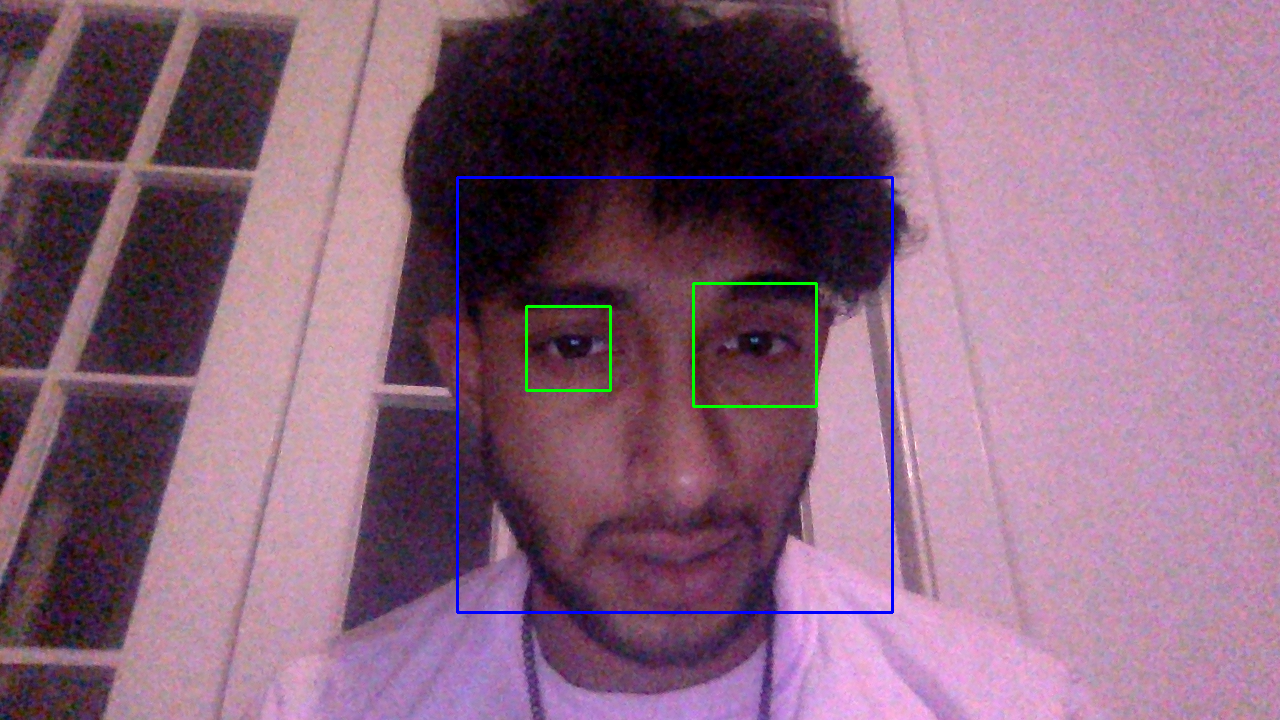

In [13]:
# Initialize the HaarCascadeBlobCapture class
haar_capture = HaarCascadeBlobCapture()
haar_capture.init_blob_detector()

# Initialize the webcam
cap = cv2.VideoCapture(0)

# Set the maximum number of frames to display
max_frames = 25
frame_count = 0

while frame_count < max_frames:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Convert the frame to grayscale for better detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Extract the face region for eye detection
        face_gray = gray[y:y+h, x:x+w]
        
        # applying histogram equalization to enhance the contrast of the grayscale image:
        face_gray = cv2.equalizeHist(face_gray)

        face_color = frame[y:y+h, x:x+w]

        # Detect eyes in the face region
        eyes = eye_detector.detectMultiScale(face_gray)

        for (ex, ey, ew, eh) in eyes:
            # Draw a rectangle around the eyes
            cv2.rectangle(face_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
            
        left, right = haar_capture.detect_eyes(face_gray)

        if left is not None:
            left_processed = cv2.erode(left, None, iterations=1)
            left_processed = cv2.dilate(left_processed, None, iterations=3)
            left_processed = cv2.medianBlur(left_processed, 5)
            left_blobs = detector.detect(left_processed)
            face_color = haar_capture.draw(face_color, left_blobs, (x, y))

        if right is not None:
            right_processed = cv2.erode(right, None, iterations=1)
            right_processed = cv2.dilate(right_processed, None, iterations=3)
            right_processed = cv2.medianBlur(right_processed, 5)
            right_blobs = detector.detect(right_processed)
            face_color = haar_capture.draw(face_color, right_blobs, (x, y))

    # Encode the frame as a PNG image
    ret, buffer = cv2.imencode('.png', frame)
    io_buf = io.BytesIO(buffer)

    # Display the image in the notebook
    IPython.display.display(IPython.display.Image(data=io_buf.getvalue()))

    # Clear the output to update the display with the next frame
    clear_output(wait=True)
    
    # Increment the frame counter
    frame_count += 1
    
    # Control the frame rate (optional)
    time.sleep(0.1)

# Release the webcam
cap.release()


In [6]:
!tccutil reset Camera

tccutil: Failed to reset Camera


In [4]:
cap = cv2.VideoCapture(0)

Left eye direction: center
Right eye direction: center
Left eye direction: center
Right eye direction: center


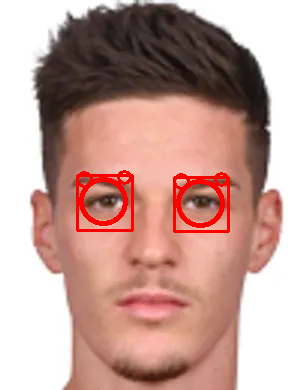

In [16]:
import cv2
import io
from IPython.display import Image

# Set up the blob detector parameters
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 10
params.maxThreshold = 200
params.filterByArea = True
params.minArea = 15
params.filterByCircularity = True
params.minCircularity = 0.1
params.filterByConvexity = True
params.minConvexity = 0.87
params.filterByInertia = True
params.minInertiaRatio = 0.01
params.blobColor = 255

# params = cv2.SimpleBlobDetector_Params()
# params.filterByArea = True
# params.maxArea = 1500

detector = cv2.SimpleBlobDetector_create(params)

def get_eyes(face):
    eyes = eye_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    left = None
    right = None
    
    if len(eyes) == 0:
        return None, None
    
    else:
        for (x, y, w, h) in eyes:
            # source: https://github.com/stepacool/Eye-Tracker/blob/master/project/capturers/haar_blob.py
            
            eye_center = int(float(x) + (float(w) / float(2))) 
            if int(face.shape[1] * 0.1) < eye_center < int(face.shape[1] * 0.4):
                left = face[y : y + h, x : x + w]
            elif int(face.shape[1] * 0.5) < eye_center < int(face.shape[1] * 0.9):
                right = face[y : y + h, x : x + w]
            else:
                pass  # false positive - nostrill
            
        return left, right
    
def draw(img, blobs, eye_coordinates, dest=None): #
    if dest is None:
        dest = img

    for blob in blobs:
        x, y = eye_coordinates
        center = (int(blob.pt[0]) + x, int(blob.pt[1]) + y)
        radius = int(blob.size / 2)
        cv2.circle(dest, center, radius, (0, 0, 255), 2)

    return dest

def process_eye(eye):
    eye = cv2.erode(eye, None, iterations=2)
    eye = cv2.dilate(eye, None, iterations=4)
    eye = cv2.medianBlur(eye, 5)
    return eye

def detect_pupil_direction(eye, pupil, w):
    center = w // 2
    if pupil.pt[0] < center - w * 0.15:
        return 'left'
    elif pupil.pt[0] > center + w * 0.15:
        return 'right'
    else:
        return 'center'

def detect_pupils_and_direction(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    eyes = eye_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in eyes:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        left, right = get_eyes(gray)

        left_processed = process_eye(left)
        left_pupil = detector.detect(left_processed)
        img = draw(img, left_pupil, (x, y))

        direction = detect_pupil_direction(left, left_pupil[0], w) if left_pupil else 'unknown'
        print(f"Left eye direction: {direction}")

        right_processed = process_eye(right)
        right_pupil = detector.detect(right_processed)
        img = draw(img, right_pupil, (x, y))

        direction = detect_pupil_direction(right, right_pupil[0], w) if right_pupil else 'unknown'
        print(f"Right eye direction: {direction}")

    return img

# Usage
image_path = 'dump/man.png'
output_image = detect_pupils_and_direction(image_path)

# Display the output image
ret, buffer = cv2.imencode('.png', output_image)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))


Right eye direction: center
Right eye direction: center


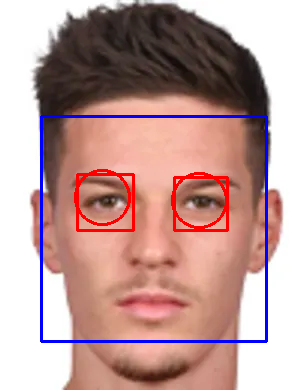

In [19]:
import cv2
import io
from IPython.display import Image

# Set up the blob detector parameters
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 10
params.maxThreshold = 200
params.filterByArea = True
params.minArea = 15
params.filterByCircularity = True
params.minCircularity = 0.1
params.filterByConvexity = True
params.minConvexity = 0.87
params.filterByInertia = True
params.minInertiaRatio = 0.01
params.blobColor = 255

# params = cv2.SimpleBlobDetector_Params()
# params.filterByArea = True
# params.maxArea = 1500

detector = cv2.SimpleBlobDetector_create(params)

def get_eyes(face):
    eyes = eye_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    left = None
    right = None
    
    if len(eyes) == 0:
        return None, None
    
    else:
        for (x, y, w, h) in eyes:
            # source: https://github.com/stepacool/Eye-Tracker/blob/master/project/capturers/haar_blob.py
            
            eye_center = int(float(x) + (float(w) / float(2))) 
            if int(face.shape[1] * 0.1) < eye_center < int(face.shape[1] * 0.4):
                left = face[y : y + h, x : x + w]
            elif int(face.shape[1] * 0.5) < eye_center < int(face.shape[1] * 0.9):
                right = face[y : y + h, x : x + w]
            else:
                pass  # false positive - nostrill
            
        return left, right
    
def draw(img, blobs, eye_coordinates, dest=None): #
    if dest is None:
        dest = img

    for blob in blobs:
        x, y = eye_coordinates
        center = (int(blob.pt[0]) + x, int(blob.pt[1]) + y)
        radius = int(blob.size / 2)
        cv2.circle(dest, center, radius, (0, 0, 255), 2)

    return dest

def process_eye(eye):
    eye = cv2.erode(eye, None, iterations=2)
    eye = cv2.dilate(eye, None, iterations=4)
    eye = cv2.medianBlur(eye, 5)
    return eye

def detect_pupil_direction(eye, pupil, w):
    center = w // 2
    if pupil.pt[0] < center - w * 0.15:
        return 'left'
    elif pupil.pt[0] > center + w * 0.15:
        return 'right'
    else:
        return 'center'

def detect_pupils_and_direction(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face_detector = cv2.CascadeClassifier(haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No face detected")
        return img

    face_x, face_y, face_w, face_h = faces[0]
    cv2.rectangle(img, (face_x, face_y), (face_x + face_w, face_y + face_h), (255, 0, 0), 2)
    face_gray = gray[face_y:face_y + face_h, face_x:face_x + face_w]

    eyes = eye_detector.detectMultiScale(face_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in eyes:
        cv2.rectangle(img, (face_x + x, face_y + y), (face_x + x + w, face_y + y + h), (0, 0, 255), 2)
        left, right = get_eyes(face_gray)

        if left is not None:
            left_processed = process_eye(left)
            left_pupil = detector.detect(left_processed)
            img = draw(img, left_pupil, (face_x + x, face_y + y))
            direction = detect_pupil_direction(left, left_pupil[0], w) if left_pupil else 'unknown'
            print(f"Left eye direction: {direction}")

        if right is not None:
            right_processed = process_eye(right)
            right_pupil = detector.detect(right_processed)
            img = draw(img, right_pupil, (face_x + x, face_y + y))
            direction = detect_pupil_direction(right, right_pupil[0], w) if right_pupil else 'unknown'
            print(f"Right eye direction: {direction}")

    return img

# Usage
image_path = 'dump/man.png'
output_image = detect_pupils_and_direction(image_path)

# Display the output image
ret, buffer = cv2.imencode('.png', output_image)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))


Left eye direction: center
Right eye direction: center


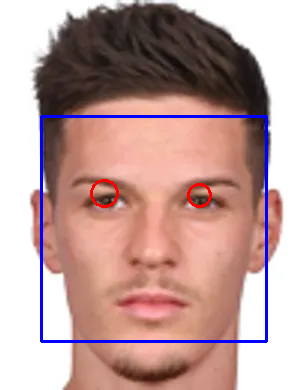

In [13]:
import cv2
import io
from IPython.display import Image

face_cascade = cv2.CascadeClassifier(haarcascades + "haarcascade_frontalface_default.xml")
eye_detector = cv2.CascadeClassifier(haarcascades + "haarcascade_eye.xml")

# Set up the blob detector parameters
# params = cv2.SimpleBlobDetector_Params()
# params.minThreshold = 10
# params.maxThreshold = 200
# params.filterByArea = True
# params.minArea = 15
# params.filterByCircularity = True
# params.minCircularity = 0.1
# params.filterByConvexity = True
# params.minConvexity = 0.87
# params.filterByInertia = True
# params.minInertiaRatio = 0.01
# params.blobColor = 255

params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.maxArea = 1500

detector = cv2.SimpleBlobDetector_create(params)

def no_eyebrows(eye):
    if eye is not None:
        eye = eye[int(eye.shape[0] * 0.3):, :]
    return eye

def get_eyes(face):
    eyes = eye_detector.detectMultiScale(face, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    left = None
    right = None

    if len(eyes) == 0:
        return None, None

    else:
        for (x, y, w, h) in eyes:
            eye_center = int(float(x) + (float(w) / float(2)))
            if int(face.shape[1] * 0.1) < eye_center < int(face.shape[1] * 0.4):
                left = (x, y, w, h, no_eyebrows(face[y : y + h, x : x + w]))
            elif int(face.shape[1] * 0.5) < eye_center < int(face.shape[1] * 0.9):
                right = (x, y, w, h, no_eyebrows(face[y : y + h, x : x + w]))
            else:
                pass  # false positive - nostrill

        return left, right
    
def draw(img, blobs, eye_coordinates, dest=None): #
    if dest is None:
        dest = img

    for blob in blobs:
        x, y = eye_coordinates
        center = (int(blob.pt[0]) + x, int(blob.pt[1]) + y)
        radius = int(blob.size / 4)
        cv2.circle(dest, center, radius, (0, 0, 255), 2)

    return dest

def process_eye(eye):
    eye = cv2.erode(eye, None, iterations=2)
    eye = cv2.dilate(eye, None, iterations=4)
    eye = cv2.medianBlur(eye, 5)
    return eye

def detect_pupil_direction(eye, pupil, w):
    center = w // 2
    if pupil.pt[0] < center - w * 0.15:
        return 'left'
    elif pupil.pt[0] > center + w * 0.15:
        return 'right'
    else:
        return 'center'

def detect_pupils_and_direction(image_path, save_path=None):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face_detector = cv2.CascadeClassifier(haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No face detected")
        return img

    face_x, face_y, face_w, face_h = faces[0]
    cv2.rectangle(img, (face_x, face_y), (face_x + face_w, face_y + face_h), (255, 0, 0), 2)
    face_gray = gray[face_y:face_y + face_h, face_x:face_x + face_w]

    left, right = get_eyes(face_gray)

    if left is not None:
        left_x, left_y, left_w, left_h, left_eye = left
        left_processed = process_eye(left_eye)
        left_pupil = detector.detect(left_processed)
        img = draw(img, left_pupil, (face_x + left_x, face_y + left_y))
        direction = detect_pupil_direction(left_eye, left_pupil[0], left_w) if left_pupil else 'unknown'
        print(f"Left eye direction: {direction}")

    if right is not None:
        right_x, right_y, right_w, right_h, right_eye = right
        right_processed = process_eye(right_eye)
        right_pupil = detector.detect(right_processed)
        img = draw(img, right_pupil, (face_x + right_x, face_y + right_y))
        direction = detect_pupil_direction(right_eye, right_pupil[0], right_w) if right_pupil else 'unknown'
        print(f"Right eye direction: {direction}")
        
    # Save the output image if a save_path is provided
    if save_path is not None:
        cv2.imwrite(save_path, img)

    return img

# Usage
image_path = 'dump/man.png'
output_image = detect_pupils_and_direction(image_path, save_path=None)

# Display the output image
ret, buffer = cv2.imencode('.png', output_image)
io_buf = io.BytesIO(buffer)
display(Image(io_buf.getvalue()))


In [20]:
import cv2
import time

# Open the webcam
cap = cv2.VideoCapture(0)

# Check if the webcam is open
if not cap.isOpened():
    print("Error: Could not open webcam")
else:
    # Add a delay to let the camera initialize and adjust to the lighting conditions
    time.sleep(2)
    
    # Capture a single frame
    ret, frame = cap.read()

    if ret:
        # Save the frame to a temporary file
        temp_image_path = "temp_webcam_frame.png"
        cv2.imwrite(temp_image_path, frame)

        # Process the captured frame with the detect_pupils_and_direction function
        output_image_path = "output_webcam_frame.png"
        detect_pupils_and_direction(temp_image_path, output_image_path)

    else:
        print("Error: Could not read frame from webcam")

    # Release the webcam
    cap.release()


Left eye direction: left
Right eye direction: left


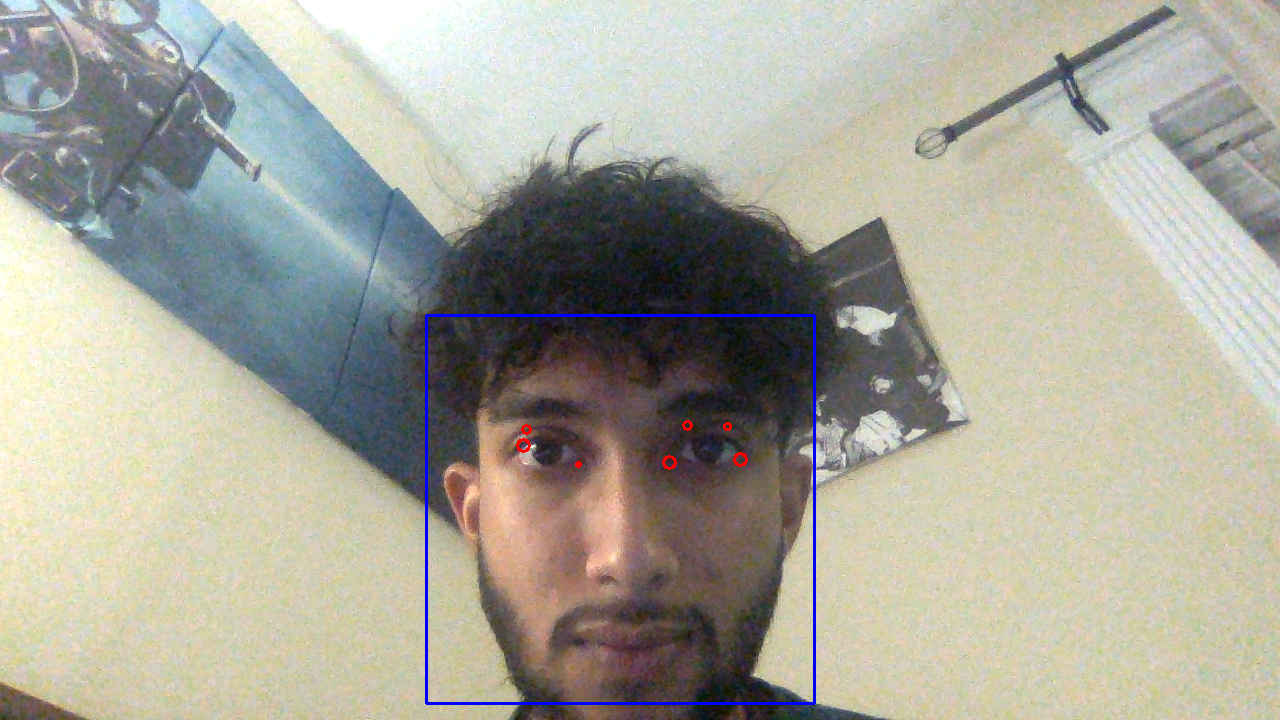

In [21]:
from IPython.display import Image
display(Image(filename=output_image_path))
